# <p style="text-align: center;">Get Weather</p>

In [43]:
#https://ecmwf-projects.github.io/copernicus-training-c3s/reanalysis-climatology.html
#https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=overview

## Import libraries

In [51]:
#!pip install xarray pandas
#!pip install netcdf4
#!pip install h5netcdf
#!pip install geopy


In [27]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import folium
from folium.plugins import MarkerCluster
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import requests
import seaborn as sns
from geopy.geocoders import Nominatim
from netCDF4 import Dataset
from scipy.stats import gaussian_kde
import xarray as xr
import zipfile


## Set parameters

In [53]:
decree_filename_base = 'arrete_'
decrees_folder_name = './../../data/raw/decrees'
communes_folder_name = './../../data/raw/opendatasoft'
weather_folder_name = './../../data/raw/weather/era5'
weather_ncfiles_folder_name = './../../data/raw/weather/era5/ncfiles'
processed_data_folder_name = './../../data/processed'
decrees_filename = 'decrees.parquet'
decrees_locations_filename = 'decrees_locations.parquet'
communes_csv_filename = 'correspondance-code-insee-code-postal.csv'
weather_filename = 'weather.parquet'
weather_shema = 'weather_shema.csv'
#weather_zip_file = "193fcd51a8958175843ecbbcaba057c8.zip"


## Unzip file

In [54]:
## (os.path.join(weather_folder_name, weather_zip_file))

In [55]:
"""

# Specify the path to the zip file and the directory to extract to
zip_file_path = (os.path.join(weather_folder_name, weather_zip_file))
extract_to_path = weather_ncfiles_folder_name

# Open the zip file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_to_path)

print("File unzipped successfully!")


"""

'\n\n# Specify the path to the zip file and the directory to extract to\nzip_file_path = (os.path.join(weather_folder_name, weather_zip_file))\nextract_to_path = weather_ncfiles_folder_name\n\n# Open the zip file in read mode\nwith zipfile.ZipFile(zip_file_path, \'r\') as zip_ref:\n    # Extract all the contents to the specified directory\n    zip_ref.extractall(extract_to_path)\n\nprint("File unzipped successfully!")\n\n\n'

## Read and merge .nc weather files

In [56]:
#df = df_weather

In [57]:
# Folder path containing .nc files
folder_path = weather_ncfiles_folder_name

# List all .nc files in the folder
nc_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.nc')]

# Read and concatenate all .nc files into a single xarray Dataset
ds = xr.open_mfdataset(nc_files, combine='by_coords')

# Convert the xarray Dataset to a pandas DataFrame
df = ds.to_dataframe().reset_index()

print(df.head())


       date  latitude  longitude  number expver       u10       v10  \
0  19900101      52.0      -5.00       0   0001  4.854118  5.280374   
1  19900101      52.0      -4.75       0   0001  4.120720  4.837014   
2  19900101      52.0      -4.50       0   0001  2.978630  3.999124   
3  19900101      52.0      -4.25       0   0001  2.781364  3.996194   
4  19900101      52.0      -4.00       0   0001  2.592888  3.729104   

          t2m           sp        tp  ...      tcrw        stl1        stl2  \
0  281.949219  100561.1875  0.004912  ...  0.009117  281.940674  281.824951   
1  281.458984  100306.1875  0.005552  ...  0.010391  281.493408  281.375732   
2  280.863281   99834.1875  0.005424  ...  0.009438  280.300049  280.006592   
3  280.437500   99420.1875  0.006426  ...  0.010941  279.934814  279.651123   
4  279.666016   98529.1875  0.007340  ...  0.012314  279.288330  279.022217   

   slt     swvl1     swvl2       cvh       cvl   tvh  tvl  
0  0.0  0.186213  0.187341  0.000000  

## Columns description

In [58]:
df.columns

Index(['date', 'latitude', 'longitude', 'number', 'expver', 'u10', 'v10',
       't2m', 'sp', 'tp', 'e', 'sro', 'tcrw', 'stl1', 'stl2', 'slt', 'swvl1',
       'swvl2', 'cvh', 'cvl', 'tvh', 'tvl'],
      dtype='object')

| Column    | Description                                      |
|-----------|--------------------------------------------------|
| date      | The date of the observation.                     |
| latitude  | The latitude coordinate of the observation point.|
| longitude | The longitude coordinate of the observation point.|
| number    | A unique identifier for the observation.         |
| expver    | Experiment version number.                       |
| u10       | 10-meter U-component of wind (eastward wind).    |
| v10       | 10-meter V-component of wind (northward wind).   |
| t2m       | 2-meter temperature (air temperature at 2 meters above the surface).|
| sp        | Surface pressure.                                |
| tp        | Total precipitation.                             |
| e         | Evaporation.                                     |
| sro       | Surface runoff.                                  |
| tcrw      | Total column water vapor.                        |
| stl1      | Soil temperature level 1.                        |
| stl2      | Soil temperature level 2.                        |
| slt       | Soil type.                                       |
| swvl1     | Volumetric soil water layer 1.                   |
| swvl2     | Volumetric soil water layer 2.                   |
| cvh       | High vegetation cover.                           |
| cvl       | Low vegetation cover.                            |
| tvh       | High vegetation type.                            |
| tvl       | Low vegetation type.                             |


## Column temperatures

In [59]:
df[['t2m','stl1', 'stl2']].describe()

,t2m,stl1,stl2
count,972192.000000,972192.000000,972192.000000
mean,284.948151,285.371765,285.260864
std,6.006083,6.001902,5.854948
min,257.364258,263.356934,264.196289
25%,280.623779,280.720215,280.664551
50%,285.065674,285.776367,285.668213
75%,289.634033,290.016602,289.792786
max,302.022461,304.711914,303.523438


### Convert temperatures from Kelvin to Celsius

In [60]:
# Function to convert Kelvin to Celsius
def kelvin_to_celsius(kelvin):
    return kelvin - 273.15


In [61]:
# Apply the function to multiple columns
columns_to_convert = ['t2m','stl1', 'stl2']
for column in columns_to_convert:
    df[column] = df[column].apply(kelvin_to_celsius)

In [62]:
df[['t2m','stl1', 'stl2']].describe()

,t2m,stl1,stl2
count,972192.000000,972192.000000,972192.000000
mean,11.798119,12.221794,12.110854
std,6.006083,6.001902,5.854948
min,-15.785742,-9.793066,-8.953711
25%,7.473779,7.570215,7.514551
50%,11.915674,12.626367,12.518213
75%,16.484033,16.866602,16.642786
max,28.872461,31.561914,30.373438


In [63]:
df['date']

0         19900101
1         19900101
2         19900101
3         19900101
4         19900101
            ...   
972187    20240801
972188    20240801
972189    20240801
972190    20240801
972191    20240801
Name: date, Length: 972192, dtype: int64

## Columns type

In [64]:
df.dtypes

date           int64
latitude     float64
longitude    float64
number         int64
expver        object
u10          float32
v10          float32
t2m          float64
sp           float32
tp           float32
e            float32
sro          float32
tcrw         float32
stl1         float64
stl2         float64
slt          float32
swvl1        float32
swvl2        float32
cvh          float32
cvl          float32
tvh          float32
tvl          float32
dtype: object

### Converte date type to datetime

In [65]:
df['date'].head()

0    19900101
1    19900101
2    19900101
3    19900101
4    19900101
Name: date, dtype: int64

In [66]:
# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [67]:
df['date'].head()

0   1990-01-01
1   1990-01-01
2   1990-01-01
3   1990-01-01
4   1990-01-01
Name: date, dtype: datetime64[ns]

In [68]:
df['date'].describe()

count                           972192
mean     2007-04-16 22:43:50.769230592
min                1990-01-01 00:00:00
25%                1998-08-24 06:00:00
50%                2007-04-16 00:00:00
75%                2015-12-08 18:00:00
max                2024-08-01 00:00:00
Name: date, dtype: object

### Convert categorical data type to object

In [69]:
# List of columns to convert
columns_to_convert = ['slt', 'tvh', 'tvl', 'number', 'expver']

# Convert columns to object type
df[columns_to_convert] = df[columns_to_convert].astype('object')

In [70]:
df[columns_to_convert].describe()

,slt,tvh,tvl,number,expver
count,972192.0,972192.0,972192.0,972192,972192
unique,5.0,5.0,8.0,1,2
top,2.0,19.0,1.0,0,0001
freq,418080.0,702208.0,695552.0,972192,967518


In [71]:
df.dtypes

date         datetime64[ns]
latitude            float64
longitude           float64
number               object
expver               object
u10                 float32
v10                 float32
t2m                 float64
sp                  float32
tp                  float32
e                   float32
sro                 float32
tcrw                float32
stl1                float64
stl2                float64
slt                  object
swvl1               float32
swvl2               float32
cvh                 float32
cvl                 float32
tvh                  object
tvl                  object
dtype: object

In [72]:
df.shape

(972192, 22)

In [73]:
## Check for dupicates

In [74]:
# Count the number of duplicates in the specified columns
num_duplicates = df.duplicated(subset=['date', 'latitude', 'longitude']).sum()

print(num_duplicates)

0


In [75]:
### Drop 

In [76]:
# we can safely drop columns 'number',	'expver' related to weathe simuation, cause we don't have duplicates. one observation per time, no mater the experiment number
df = df.drop(['number', 'expver'], axis=1)

## Coordinates 

In [77]:
df[['latitude', 'longitude']].describe()

,latitude,longitude
count,972192.000000,972192.00000
mean,47.000000,2.00000
std,2.958041,4.11299
min,42.000000,-5.00000
25%,44.500000,-1.50000
50%,47.000000,2.00000
75%,49.500000,5.50000
max,52.000000,9.00000


In [78]:
"""
# Create a map centered around the average latitude and longitude
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Add points to the map using MarkerCluster
marker_cluster = MarkerCluster().add_to(m)
for idx, row in df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(marker_cluster)

# Display the map
m
"""

"\n# Create a map centered around the average latitude and longitude\nm = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)\n\n# Add points to the map using MarkerCluster\nmarker_cluster = MarkerCluster().add_to(m)\nfor idx, row in df.iterrows():\n    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(marker_cluster)\n\n# Display the map\nm\n"

## Standard reference period and climate normals 

### Note

>Until 2020, the most current and widely used standard reference period was the 30-year range of 1981-2010. With the start of 2021, the WMO recommended updating the climate normal reference period to the range 1991-2020.

In [79]:
df.dtypes

date         datetime64[ns]
latitude            float64
longitude           float64
u10                 float32
v10                 float32
t2m                 float64
sp                  float32
tp                  float32
e                   float32
sro                 float32
tcrw                float32
stl1                float64
stl2                float64
slt                  object
swvl1               float32
swvl2               float32
cvh                 float32
cvl                 float32
tvh                  object
tvl                  object
dtype: object

In [80]:
# Identify float columns
measure_columns = df.select_dtypes(include=['float32', 'float64']).columns.tolist()

# Remove latitude and longitude
measure_columns = [col for col in measure_columns if col not in ['longitude', 'latitude']]

print(measure_columns)

['u10', 'v10', 't2m', 'sp', 'tp', 'e', 'sro', 'tcrw', 'stl1', 'stl2', 'swvl1', 'swvl2', 'cvh', 'cvl']


In [83]:
'''
import pandas as pd
import numpy as np

# Sample dataframe
data = {
    'date': pd.date_range(start='1/1/2000', periods=24, freq='MS'),
    'latitude': np.random.uniform(-90, 90, 24),
    'longitude': np.random.uniform(-180, 180, 24),
    'temperature': np.random.uniform(-10, 40, 24),
    'precipitation': np.random.uniform(0, 200, 24)
}
df = pd.DataFrame(data)
'''

# Convert date to datetime and extract month and year
# df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Filter data for the reference period (1990-2010)
ref_period = df[(df['year'] >= 1990) & (df['year'] <= 2010)]

# Initialize reference columns
for measure in measure_columns:
    # mean of monthly measures of a location over the reference period
    ref_col = f'{measure}_ref'
    # standard deviation of monthly measures of a location over the reference period
    std_col = f'{measure}_std'
    # standard deviation of monthly measures of a location over the reference period
    delta_col = f'{measure}_delta'
    # z_transformation taking the reference mean and the reference std of monthly measures of a location over the reference period
    # this is part of the process of building a simplified extreame weather mesure indicator
    z_col = f'{measure}_z'
    
    
    # Calculate monthly mean for each location
    monthly_mean = ref_period.groupby(['latitude', 'longitude', 'month'])[measure].mean().reset_index()
    monthly_std = ref_period.groupby(['latitude', 'longitude', 'month'])[measure].std().reset_index()
    monthly_mean.columns = ['latitude', 'longitude', 'month', ref_col]
    monthly_std.columns = ['latitude', 'longitude', 'month', std_col]
        
    # Merge reference data with the original dataframe
    df = pd.merge(df, monthly_mean, on=['latitude', 'longitude', 'month'], how='left')
    df = pd.merge(df, monthly_std, on=['latitude', 'longitude', 'month'], how='left')
    
    # Calculate delta
    df[delta_col] = df[measure] - df[ref_col]
    # Calculate z_score using mean and std of the reference period
    df[z_col] = (df[measure] - df[ref_col] )/ ( df[std_col])

# Display the dataframe
print(df)


             date  latitude  longitude       u10       v10        t2m  \
0      1990-01-01      52.0      -5.00  4.854118  5.280374   8.799219   
1      1990-01-01      52.0      -4.75  4.120720  4.837014   8.308984   
2      1990-01-01      52.0      -4.50  2.978630  3.999124   7.713281   
3      1990-01-01      52.0      -4.25  2.781364  3.996194   7.287500   
4      1990-01-01      52.0      -4.00  2.592888  3.729104   6.516016   
...           ...       ...        ...       ...       ...        ...   
972187 2024-08-01      42.0       8.00  1.438617 -0.738438  26.516504   
972188 2024-08-01      42.0       8.25  1.178851 -0.563145  26.979395   
972189 2024-08-01      42.0       8.50  0.999652 -0.279453  26.137598   
972190 2024-08-01      42.0       8.75  0.703265 -0.061680  24.969629   
972191 2024-08-01      42.0       9.00  0.246722  0.062832  23.719629   

                 sp        tp         e       sro  ...  swvl2_delta   swvl2_z  \
0       100561.1875  0.004912 -0.001651  0

In [86]:
df[['date', 'longitude', 'latitude', 't2m','t2m_ref','t2m_delta', 't2m_z']]

,date,longitude,latitude,t2m,t2m_ref,t2m_delta,t2m_z
0,1990-01-01,-5.00,52.0,8.799219,7.136981,1.662237,1.278302
1,1990-01-01,-4.75,52.0,8.308984,6.522677,1.786307,1.278592
2,1990-01-01,-4.50,52.0,7.713281,5.749705,1.963577,1.268917
3,1990-01-01,-4.25,52.0,7.287500,5.332294,1.955206,1.267388
4,1990-01-01,-4.00,52.0,6.516016,4.571133,1.944882,1.265657
...,...,...,...,...,...,...,...
972187,2024-08-01,8.00,42.0,26.516504,24.017178,2.499326,2.200762
972188,2024-08-01,8.25,42.0,26.979395,24.679567,2.299828,2.093247
972189,2024-08-01,8.50,42.0,26.137598,23.726442,2.411156,2.146372
972190,2024-08-01,8.75,42.0,24.969629,22.386598,2.583031,2.120975


In [87]:
df[(df['longitude'] == -4.50	) & (df['latitude'] == 52.0) & \
    (df['year'].isin([1990, 2000])) & (df['month'].isin([1,2]))][['date', 'longitude', 'latitude', 't2m','t2m_ref','t2m_delta', 't2m_z']]

,date,longitude,latitude,t2m,t2m_ref,t2m_delta,t2m_z
2,1990-01-01,-4.5,52.0,7.713281,5.749705,1.963577,1.268917
2339,1990-02-01,-4.5,52.0,7.987939,5.769073,2.218866,1.474079
280442,2000-01-01,-4.5,52.0,5.898828,5.749705,0.149123,0.096368
282779,2000-02-01,-4.5,52.0,7.053857,5.769073,1.284784,0.853532


In [88]:
max_abs_t2m_delta_row = df.loc[df['t2m_delta'].abs().idxmax(), ['date', 'longitude', 'latitude','t2m','t2m_ref','t2m_delta']]
print(max_abs_t2m_delta_row)

date         2024-02-01 00:00:00
longitude                    7.5
latitude                    46.0
t2m                    -1.679297
t2m_ref                -10.26227
t2m_delta               8.582973
Name: 957251, dtype: object


In [90]:


# Assuming your dataframe is named df
filtered_df = df[(df['longitude'] == 7.5) & (df['latitude'] == 46.0)]

fig = px.line(filtered_df, x='date', y='t2m_delta', title='t2m_delta over Time for Longitude 7.5 and Latitude 46.0')
fig.show()

In [91]:
# Create the plot with a trendline
fig = px.scatter(filtered_df, x='date', y='t2m_delta', trendline='ols', title='t2m_delta over Time for Longitude 7.5 and Latitude 46.0')

# Convert scatter plot to line plot
fig.update_traces(mode='lines+markers')

fig.show()

In [38]:
import folium

# Coordinates
latitude = 46.0
longitude = 7.5

# Create a map centered around the coordinates
m = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add a marker to the map
folium.Marker([latitude, longitude], popup='Location').add_to(m)

# Save the map to an HTML file
m.save('map.html')

# Display the map
m


In [92]:
#The ERA5 data square we define includes some parts of bordering countries.

In [16]:
#!pip install selenium
#!pip install webdriver_manager
#!pip install weasyprint
!pip install wkhtmltoimage

ERROR: Could not find a version that satisfies the requirement wkhtmltoimage (from versions: none)
ERROR: No matching distribution found for wkhtmltoimage


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import gaussian_kde

# Constants for data generation
num_stations = 1925
latitude_bounds = [41.0, 51.5]  # Approximate latitude range for France
longitude_bounds = [-5.0, 9.5]  # Approximate longitude range for France
output_data_folder_name = './../../data/processed/output'

# User inputs for start and end year, and start and end month
start_year = int(input("Enter the start year for the analysis (between 1940 and 2024): "))
end_year = int(input("Enter the end year for the analysis (between 1940 and 2024): "))
start_month = int(input("Enter the start month (1-12): "))
end_month = int(input("Enter the end month (1-12): "))
frame_spacing = float(input("Enter the spacing (in seconds) for displaying each frame in the GIF: "))

# Generate monthly dates from the user-defined range
date_range = pd.date_range(start=f'{start_year}-{start_month:02}', end=f'{end_year}-{end_month:02}', freq='M')

# Create a list to store all records
records = []

# Generate data for each station and each month
for station_id in range(1, num_stations + 1):
    # Randomly generate latitude and longitude within France's approximate boundaries
    latitude = np.random.uniform(latitude_bounds[0], latitude_bounds[1])
    longitude = np.random.uniform(longitude_bounds[0], longitude_bounds[1])
    
    # Generate data for each month in the date range
    for date in date_range:
        temperature = np.random.normal(loc=12, scale=10)  # Average temperature with some variability
        precipitation = np.random.uniform(0, 200)  # Monthly precipitation in mm
        
        records.append({
            'station_id': station_id,
            'latitude': latitude,
            'longitude': longitude,
            'date': date,
            'temperature': round(temperature, 2),  # Rounded to make more realistic
            'precipitation': round(precipitation, 2)  # Rounded to make more realistic
        })

# Create a DataFrame from the generated records
df = pd.DataFrame(records)

# Ensure output directory exists
if not os.path.exists(output_data_folder_name):
    os.makedirs(output_data_folder_name)

# Create frames for each month and save as PNG
png_files = []
for date in date_range:
    # Filter data for the current month
    monthly_data = df[df['date'] == date]
    
    # Prepare data for heatmap
    xy = np.vstack([monthly_data['longitude'], monthly_data['latitude']])
    kde = gaussian_kde(xy, bw_method=0.1)
    lon_linspace = np.linspace(longitude_bounds[0], longitude_bounds[1], 100)
    lat_linspace = np.linspace(latitude_bounds[0], latitude_bounds[1], 100)
    lon_grid, lat_grid = np.meshgrid(lon_linspace, lat_linspace)
    kde_values = kde(np.vstack([lon_grid.ravel(), lat_grid.ravel()])).reshape(lon_grid.shape)
    
    # Plotting the heatmap on a map
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([longitude_bounds[0], longitude_bounds[1], latitude_bounds[0], latitude_bounds[1]], ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    ax.add_feature(cfeature.RIVERS)
    
    # Plot heatmap
    heatmap = ax.contourf(lon_grid, lat_grid, kde_values, levels=20, cmap='coolwarm', alpha=0.6, transform=ccrs.PlateCarree())
    
    # Title and save
    ax.set_title(f"Weather Stations - {date.strftime('%B %Y')}")
    frame_filename = f"{output_data_folder_name}/frame_{date.strftime('%Y_%m')}.png"
    plt.savefig(frame_filename, bbox_inches='tight', dpi=150)
    png_files.append(frame_filename)
    plt.close()

# Create a GIF from the saved PNGs
with imageio.get_writer(f'{output_data_folder_name}/weather_animation.gif', mode='I', duration=frame_spacing, loop=0) as writer:
    for filename in png_files:
        if os.path.exists(filename):
            image = imageio.imread(filename)
            writer.append_data(image)

# Clean up PNG files (optional)
for filename in png_files:
    if os.path.exists(filename):
        os.remove(filename)

print("GIF animation of weather station data has been successfully generated and saved as weather_animation.gif.")

/tmp/ipykernel_682803/246723349.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=f'{start_year}-{start_month:02}', end=f'{end_year}-{end_month:02}', freq='M')
/tmp/ipykernel_682803/246723349.py:94: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF animation of weather station data has been successfully generated and saved as weather_animation.gif.


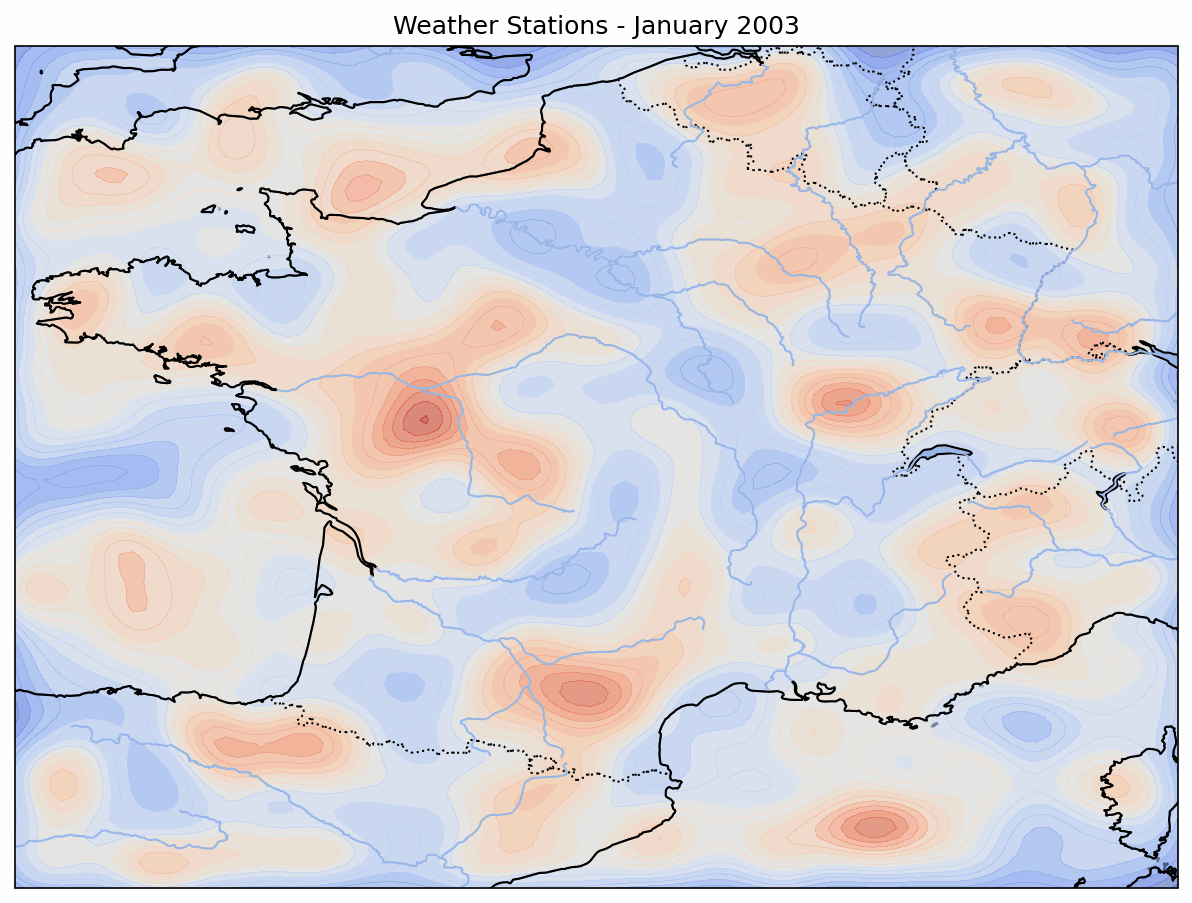

In [26]:
from IPython.display import Image

# Replace 'path_to_your_gif.gif' with the path to your gif
Image(filename=f'{output_data_folder_name}/weather_animation.gif')


## Save processed weather data

In [93]:
# save to parquet
df.to_parquet(os.path.join(processed_data_folder_name, weather_filename))

In [94]:
# Save the schema (data types) to a file
df.dtypes.to_csv(os.path.join(processed_data_folder_name, weather_shema))

## Test reloading

In [95]:
# test reloading the dataframe from parquet
import pandas as pd

df_reloaded = pd.read_parquet(os.path.join(processed_data_folder_name, weather_filename))




In [96]:
os.path.join(processed_data_folder_name, weather_shema)

'./../../data/processed/weather_shema.csv'

In [97]:
# Load the schema (data types) from the file
schema = pd.read_csv(os.path.join(processed_data_folder_name, weather_shema), index_col=0).squeeze("columns")

In [98]:
# Apply the schema to the loaded dataframe
df_reloaded = df_reloaded.astype(schema.to_dict())

In [99]:
# Check if dtypes are the same
assert df_reloaded.dtypes.equals(schema), "Data types do not match!"

In [100]:
df_reloaded.head()

,date,latitude,longitude,u10,v10,t2m,sp,tp,e,sro,...,swvl2_delta,swvl2_z,cvh_ref,cvh_std,cvh_delta,cvh_z,cvl_ref,cvl_std,cvl_delta,cvl_z
0,1990-01-01,52.0,-5.00,4.854118,5.280374,8.799219,100561.1875,0.004912,-0.001651,0.000077,...,0.004298,0.734757,0.000000,0.0,0.0,NaN,0.000000,0.0,0.0,NaN
1,1990-01-01,52.0,-4.75,4.120720,4.837014,8.308984,100306.1875,0.005552,-0.001413,0.000115,...,0.005095,0.924681,0.000000,0.0,0.0,NaN,0.000000,0.0,0.0,NaN
2,1990-01-01,52.0,-4.50,2.978630,3.999124,7.713281,99834.1875,0.005424,-0.000871,0.000253,...,0.010266,0.819139,0.444855,0.0,0.0,NaN,0.294592,0.0,0.0,NaN
3,1990-01-01,52.0,-4.25,2.781364,3.996194,7.287500,99420.1875,0.006426,-0.000815,0.000324,...,0.012148,0.903294,0.236176,0.0,0.0,NaN,0.737630,0.0,0.0,NaN
4,1990-01-01,52.0,-4.00,2.592888,3.729104,6.516016,98529.1875,0.007340,-0.000660,0.000378,...,0.014235,0.994208,0.440437,0.0,0.0,NaN,0.559563,0.0,0.0,NaN


In [101]:
df_reloaded.equals(df)

True

In [102]:
df_reloaded.describe()

/opt/mamba/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract

/opt/mamba/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract

/opt/mamba/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning:

invalid value encountered in reduce

/opt/mamba/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning:

invalid value encountered in subtract

/opt/mamba/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning:

invalid value encountered in reduce

/opt/mamba/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning:

invalid value encountered in subtract



,date,latitude,longitude,u10,v10,t2m,sp,tp,e,sro,...,swvl2_delta,swvl2_z,cvh_ref,cvh_std,cvh_delta,cvh_z,cvl_ref,cvl_std,cvl_delta,cvl_z
count,972192,972192.000000,972192.00000,972192.000000,972192.000000,972192.000000,972192.000000,972192.000000,972192.000000,972192.000000,...,9.721920e+05,972192.000000,972192.000000,972192.0,9.721920e+05,42848.0,972192.000000,972192.0,9.721920e+05,96928.0
mean,2007-04-16 22:43:50.769230592,47.000000,2.00000,0.894162,0.045310,11.798119,98341.687500,0.002557,-0.001944,0.000145,...,-2.604512e-03,-0.075546,0.361099,0.0,-2.454834e-10,NaN,0.343085,0.0,-2.550477e-10,NaN
min,1990-01-01 00:00:00,42.000000,-5.00000,-6.515217,-11.582765,-15.785742,74445.875000,0.000000,-0.011114,0.000000,...,-2.483993e-01,-11.320975,0.000000,0.0,-5.960464e-08,-inf,0.000000,0.0,-5.960464e-08,-inf
25%,1998-08-24 06:00:00,44.500000,-1.50000,0.016057,-0.731009,7.473779,97283.625000,0.001396,-0.002775,0.000002,...,-1.209159e-02,-0.765555,0.000000,0.0,0.000000e+00,NaN,0.000000,0.0,0.000000e+00,NaN
50%,2007-04-16 00:00:00,47.000000,2.00000,0.664992,-0.001555,11.915674,100072.687500,0.002264,-0.001892,0.000022,...,6.128241e-07,0.015887,0.266821,0.0,0.000000e+00,NaN,0.276017,0.0,0.000000e+00,NaN
75%,2015-12-08 18:00:00,49.500000,5.50000,1.563922,0.821745,16.484033,101302.437500,0.003376,-0.000998,0.000098,...,1.087640e-02,0.701432,0.657410,0.0,0.000000e+00,NaN,0.642772,0.0,0.000000e+00,NaN
max,2024-08-01 00:00:00,52.000000,9.00000,10.027842,9.043267,28.872461,104005.625000,0.029537,0.000143,0.015995,...,1.669480e-01,4.364432,1.000000,0.0,5.960464e-08,inf,0.994877,0.0,5.960464e-08,inf
std,NaN,2.958041,4.11299,1.473975,1.398554,6.006083,4579.915527,0.001642,0.001111,0.000412,...,3.182225e-02,1.074981,0.345379,0.0,9.777210e-09,NaN,0.332746,0.0,1.411973e-08,NaN


In [103]:
df.describe()

/opt/mamba/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract

/opt/mamba/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract

/opt/mamba/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning:

invalid value encountered in reduce

/opt/mamba/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning:

invalid value encountered in subtract

/opt/mamba/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning:

invalid value encountered in reduce

/opt/mamba/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning:

invalid value encountered in subtract



,date,latitude,longitude,u10,v10,t2m,sp,tp,e,sro,...,swvl2_delta,swvl2_z,cvh_ref,cvh_std,cvh_delta,cvh_z,cvl_ref,cvl_std,cvl_delta,cvl_z
count,972192,972192.000000,972192.00000,972192.000000,972192.000000,972192.000000,972192.000000,972192.000000,972192.000000,972192.000000,...,9.721920e+05,972192.000000,972192.000000,972192.0,9.721920e+05,42848.0,972192.000000,972192.0,9.721920e+05,96928.0
mean,2007-04-16 22:43:50.769230592,47.000000,2.00000,0.894162,0.045310,11.798119,98341.687500,0.002557,-0.001944,0.000145,...,-2.604512e-03,-0.075546,0.361099,0.0,-2.454834e-10,NaN,0.343085,0.0,-2.550477e-10,NaN
min,1990-01-01 00:00:00,42.000000,-5.00000,-6.515217,-11.582765,-15.785742,74445.875000,0.000000,-0.011114,0.000000,...,-2.483993e-01,-11.320975,0.000000,0.0,-5.960464e-08,-inf,0.000000,0.0,-5.960464e-08,-inf
25%,1998-08-24 06:00:00,44.500000,-1.50000,0.016057,-0.731009,7.473779,97283.625000,0.001396,-0.002775,0.000002,...,-1.209159e-02,-0.765555,0.000000,0.0,0.000000e+00,NaN,0.000000,0.0,0.000000e+00,NaN
50%,2007-04-16 00:00:00,47.000000,2.00000,0.664992,-0.001555,11.915674,100072.687500,0.002264,-0.001892,0.000022,...,6.128241e-07,0.015887,0.266821,0.0,0.000000e+00,NaN,0.276017,0.0,0.000000e+00,NaN
75%,2015-12-08 18:00:00,49.500000,5.50000,1.563922,0.821745,16.484033,101302.437500,0.003376,-0.000998,0.000098,...,1.087640e-02,0.701432,0.657410,0.0,0.000000e+00,NaN,0.642772,0.0,0.000000e+00,NaN
max,2024-08-01 00:00:00,52.000000,9.00000,10.027842,9.043267,28.872461,104005.625000,0.029537,0.000143,0.015995,...,1.669480e-01,4.364432,1.000000,0.0,5.960464e-08,inf,0.994877,0.0,5.960464e-08,inf
std,NaN,2.958041,4.11299,1.473975,1.398554,6.006083,4579.915527,0.001642,0.001111,0.000412,...,3.182225e-02,1.074981,0.345379,0.0,9.777210e-09,NaN,0.332746,0.0,1.411973e-08,NaN


In [104]:


# Assuming df and df_reloaded are your dataframes
comparison = df.compare(df_reloaded)

print(comparison)


Empty DataFrame
Columns: []
Index: []


In [105]:
print(df.shape)
print(df_reloaded.shape)


(972192, 78)
(972192, 78)


In [106]:
print(df.columns)
print(df_reloaded.columns)

Index(['date', 'latitude', 'longitude', 'u10', 'v10', 't2m', 'sp', 'tp', 'e',
       'sro', 'tcrw', 'stl1', 'stl2', 'slt', 'swvl1', 'swvl2', 'cvh', 'cvl',
       'tvh', 'tvl', 'month', 'year', 'u10_ref', 'u10_std', 'u10_delta',
       'u10_z', 'v10_ref', 'v10_std', 'v10_delta', 'v10_z', 't2m_ref',
       't2m_std', 't2m_delta', 't2m_z', 'sp_ref', 'sp_std', 'sp_delta', 'sp_z',
       'tp_ref', 'tp_std', 'tp_delta', 'tp_z', 'e_ref', 'e_std', 'e_delta',
       'e_z', 'sro_ref', 'sro_std', 'sro_delta', 'sro_z', 'tcrw_ref',
       'tcrw_std', 'tcrw_delta', 'tcrw_z', 'stl1_ref', 'stl1_std',
       'stl1_delta', 'stl1_z', 'stl2_ref', 'stl2_std', 'stl2_delta', 'stl2_z',
       'swvl1_ref', 'swvl1_std', 'swvl1_delta', 'swvl1_z', 'swvl2_ref',
       'swvl2_std', 'swvl2_delta', 'swvl2_z', 'cvh_ref', 'cvh_std',
       'cvh_delta', 'cvh_z', 'cvl_ref', 'cvl_std', 'cvl_delta', 'cvl_z'],
      dtype='object')
Index(['date', 'latitude', 'longitude', 'u10', 'v10', 't2m', 'sp', 'tp', 'e',
       'sro', '

In [107]:
#print(df.dtypes)
print(df_reloaded.dtypes)

date         datetime64[ns]
latitude            float64
longitude           float64
u10                 float32
v10                 float32
                  ...      
cvh_z               float32
cvl_ref             float32
cvl_std             float32
cvl_delta           float32
cvl_z               float32
Length: 78, dtype: object


In [108]:
for column in df.columns:
    if column in df_reloaded.columns:
        print(f"Comparing column: {column}")
        print(df[column].compare(df_reloaded[column]))


Comparing column: date
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: latitude
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: longitude
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: u10
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: v10
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: t2m
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: sp
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: tp
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: e
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: sro
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: tcrw
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: stl1
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: stl2
Empty DataFrame
Columns: [self, other]
Index: []
Comparing column: slt
Empty DataFrame
Columns: [self, other]
Index

In [109]:
for column in df.columns:
    if column in df_reloaded.columns:
        differences = df[column].compare(df_reloaded[column])
        if not differences.empty:
            print(f"Comparing column: {column}")
            print(differences)


In [110]:
differences = df.dtypes.compare(df_reloaded.dtypes)
if not differences.empty:
    print("Differences in data types:")
    print(differences)
else:
    print("No differences in data types.")


No differences in data types.


In [111]:
'''
## when reloading, we have to convert 
slt  object  float64
tvh  object  float64
tvl  object  float64
to the appropiate format.
We may also try to save with preserving a shema.
'''


'\n## when reloading, we have to convert \nslt  object  float64\ntvh  object  float64\ntvl  object  float64\nto the appropiate format.\nWe may also try to save with preserving a shema.\n'